# Dimension Reduction

We now explore some techniques for visualizing high dimensional data. We begin with an application of Principal Component Analysis (PCA) to that end.

## PCA as Dimension Reduction

Let's return to our favorite dataset, MNIST.

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

Recal that MNIST contains handwritten digits as $8 \times 8$ images. We can think of these as vectors in $\mathbb{R}^{8 \times 8} \approx \mathbb{R}^{64}$.

In the settings below, I smoothed the displays a bit to get smoother looking images. The real data still consists of the low-resolution images we've been using. See the documentation if you want to try some other options https://matplotlib.org/gallery/images_contours_and_fields/interpolation_methods.html

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))

for j in range(10):
    fig.add_subplot(1,10,j+1)
    plt.imshow(digits.images[j], cmap='gray', interpolation = 'sinc')
    # Using different display options than what we used previously

We can think of the MNIST dataset as a *point cloud* in $\mathbb{R}^{64}$. This means it is impossible to visualize directly. On the other hand, we've seen that the data is structured enough that simple classifiation algorithms like logistic regression and SVM work extremely well. This leads us to believe that we may be able to get some sort of visualization of the data by exploiting its special structure.

We begin by applying PCA to MNIST.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(digits.data)

In [ ]:
pca.components_.shape

If we look at the explained variance ratios, we observe the following. Even though the data lives in $64$ dimensions, if we use the principal vector basis then any direction after the first 10 contributes less than 2\% of the total variance in the data!

In [ ]:
plt.plot(pca.explained_variance_ratio_)

If we only used the first couple of principal vectors as our coordinate axes, we might actually get a reasonable picture of the MNIST dataset!

In [ ]:
pVec0 = pca.components_[0]
pVec1 = pca.components_[1]

In [ ]:
pVec0

Even though each principal vector lives in $\mathbb{R}^{64}$, the first two of them still span a 2-dimensional plane. We can orthogonally project each point from the MNIST dataset onto this 2-dimensional plane. This is accomplished by taking dot products with each of the principal vectors.

In [ ]:
import numpy as np

projectedMNIST = []

for j in range(1797):
    projectedMNIST.append([np.dot(digits.data[j],pVec0),np.dot(digits.data[j],pVec1)])

projectedMNIST = np.array(projectedMNIST)

Now we can plot the projected point cloud on this two dimensional plane.

In [ ]:
plt.figure(figsize=(10,10))

plt.scatter(projectedMNIST[:, 0], projectedMNIST[:, 1],
            c=digits.target, alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral_r', 10))

plt.xlabel('pVec0')
plt.ylabel('pVec1')
plt.axis('equal')
plt.colorbar();

This gives a relatively faithful picture of the 64-dimensional MNIST dataset in only 2-dimensions. We can see the separation in the classes and this makes it more clear why logistic regression and SVM did such a good job of separating the data.

The procedure of finding a low-dimensional representation of high-dimensional data is called *dimension reduction*.

Of course this dimension reduction procedure is built into `scikit-learn`. The same effect is achieved by the following code.

In [ ]:
pca = PCA(n_components = 2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)

In [ ]:
plt.figure(figsize = (10,10))

plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral_r', 10))

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.axis('equal')
plt.colorbar();

## Visualizing Variability in the Digits

We can try to visualize what the principal directions are capturing in MNIST. We begin by pulling out all of the digits labeled '0'.

In [ ]:
zeroList = digits.target==0
zeros = digits.data[zeroList]

We can compute the 'average zero' and visualize it. 

In [ ]:
mu = []
for j in range(64):
    mu.append(np.mean(zeros[:,j]))

plt.imshow(np.array(mu).reshape(8,8),cmap='gray', interpolation = 'sinc') 

This is pretty typical for this sort of image data: the 'average' in the label class is a very symmetric representation of the class.

Next we perform PCA and get a feel for how variability is captured by the principal directions.

In [ ]:
pca = PCA()
pca.fit(zeros)

print(pca.singular_values_[:10])

plt.plot(pca.explained_variance_ratio_);

Finally, we can take a look at the variability along the first principal direction as follows. We center the average zero, then move incrementally along the first principal direction. The increments should be proportional to the first singular value. This is accomplished by the following code.

In [ ]:
# Center the mean, store first principal vector and singular value
zeros_centered = zeros - np.array(mu)
pVec1 = pca.components_[0]
pVal1 = pca.singular_values_[0]

# Create a list of offsets, proportional to the first singular value.
offset_list = [-0.4*pVal1, -0.3*pVal1, -0.2*pVal1, -0.1*pVal1, 0*pVal1, 0.1*pVal1, 0.2*pVal1, 0.3*pVal1, 0.4*pVal1]

# Create a figure displaying the result of moving the average along the principal direction.
fig = plt.figure(figsize=(20,5))

for j in range(len(offset_list)):
    offsetMu = np.array(mu) + offset_list[j]*pVec1
    fig.add_subplot(1,len(offset_list),j+1)
    plt.imshow(offsetMu.reshape(8,8), cmap='gray', interpolation = 'sinc')

Apparently, the main variability in the zeros is in their overall size. Let's write a general algorithm to visualize other directions of variability.

In [ ]:
# Define the principal vector
pvec_index = 1

pVec = pca.components_[pvec_index]
pVal = pca.singular_values_[pvec_index]

# Create a list of offsets, proportional to the first singular value.
offset_list = [-0.4*pVal, -0.3*pVal, -0.2*pVal, -0.1*pVal, 0*pVal, 0.1*pVal, 0.2*pVal, 0.3*pVal, 0.4*pVal]

# Create a figure displaying the result of moving the average along the principal direction.
fig = plt.figure(figsize=(20,5))

for j in range(len(offset_list)):
    offsetMu = np.array(mu) + offset_list[j]*pVec
    fig.add_subplot(1,len(offset_list),j+1)
    plt.imshow(offsetMu.reshape(8,8), cmap='gray', interpolation='sinc')

### Exercise

Run similar experiments for the other digit classes. (You don't really need to write new code to do this; you can just make some small changes to what we've done above.)

## Random Digits

We can generate "random" handwritten zeros by sampling from the normal distribution with center at the average zero and covariance given by the covariance of the point cloud of zeros. This is accomplished by the code below.

In [ ]:
zeroList = digits.target==0
zeros = digits.data[zeroList]

mu = []
for j in range(64):
    mu.append(np.mean(zeros[:,j]))

zeros_centered = zeros - np.array(mu)

cov = zeros_centered.T@zeros_centered

In [ ]:
fig = plt.figure(figsize=(20,10))

for j in range(10):
    zeroSample = np.random.multivariate_normal(mu, .01*cov, 1).T
    RandomZero = zeroSample.reshape(8,8)
    fig.add_subplot(1,10,j+1)
    plt.imshow(RandomZero, cmap='gray', interpolation='sinc')

Compare this to randomly selecting actual digits from the list of zeros.

In [ ]:
fig = plt.figure(figsize=(20,10))

for j in range(10):
    zeroSample = zeros[np.random.randint(0,len(zeros))]
    RandomZero = zeroSample.reshape(8,8)
    fig.add_subplot(1,10,j+1)
    plt.imshow(RandomZero, cmap='gray', interpolation='sinc')

### Exercise/Homework

Here is another classification scheme: compute the mean digit in each digit class. Then use 'distance to the mean' as your classifier: given a digit vector $\vec{x}$, label it by the digit whose mean it is closest to. How does the classification rate compare to our other methods?

## T-SNE 

T-SNE (T-distributed Stochastic Neighbor Embedding) is another recently developed dimension reduction algorithm. The problem formulation is more involved than PCA. A basic description is as follows:

#### Goal

Given a data set $\vec{x}_1,\ldots,\vec{x}_N$ of vectors $\vec{x}_j \in \mathbb{R}^d$, where $d > 3$, we seek a set $\vec{y}_1,\ldots,\vec{y}_N$ of vectors in $\mathbb{R}^k$ with $k=2$ or $3$, such that the $\vec{y}_j$ faithfully reflect the clustering behavior of the $\vec{x}_j$.

#### Similarity Scores

Similarity between data points $\vec{x}_i$ and $\vec{x}_j$ is measured by
$$
p_{ij} = \frac{1}{2N} \left( \frac{\exp (-\|\vec{x}_i - \vec{x}_j\|^2/\sigma_i^2)}{\sum_{k \neq i} \exp(-\|\vec{x}_i - \vec{x}_k\|/\sigma_i^2)} +  \frac{\exp (-\|\vec{x}_i - \vec{x}_j\|^2/\sigma_j^2)}{\sum_{k \neq j} \exp(-\|\vec{x}_j - \vec{x}_k\|/\sigma_j^2)} \right),
$$
where the widths $\sigma_i$ are chosen by an algorithm so that smaller $\sigma_i$ occur in denser parts of the point cloud.

Similarity scores between points $\vec{y}_i$ and $\vec{y}_j$ is measured by
$$
q_{ij} = \frac{\left(1+\|\vec{y}_i - \vec{y}_j\|^2\right)^{-1}}{\sum_{\ell \neq p} \left(1+\|\vec{y}_\ell - \vec{y}_p\|^2\right)^{-1}}
$$
for $i \neq j$ and we set $q_{ii} = 0$.

#### Loss Function

We then search for a set of vectors $Y = \{\vec{y}_1,\ldots,\vec{y}_N\}$ which minimize the following loss function, called *Kullback-Liebler divergence*:
$$
L(Y) = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}.
$$
This is minimized via some variant of gradient descent.

### Drawbacks of T-SNE

- The loss function is nonconvex and has many local minima. Gradient descent may converge to a "bad" local minimum.
- It is computationally expensive compared to PCA, especially for very high-dimensional data.
- Compared to PCA, it is not as readily interpretable. We don't get useful information like principal vectors which can be used to perform other tasks.

### Pros of T-SNE

It can work *amazingly* well!

In [ ]:
# Let's time the computation
import time 

from sklearn.manifold import TSNE

start = time.time()
digits_projected = TSNE(n_components=2).fit_transform(digits.data)
end = time.time()

print(end-start)

In [ ]:
plt.figure(figsize = (10,10))

plt.scatter(digits_projected[:, 0], digits_projected[:, 1],
            c=digits.target, alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral_r', 10))

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.axis('equal')
plt.colorbar();

Almost perfect clustering! If we run it again we will get a diferent answer (because the loss function doesn't have a unique minimum).

In [ ]:
start = time.time()
digits_projected = TSNE(n_components=2).fit_transform(digits.data)
end = time.time()

print(end-start)

In [ ]:
plt.figure(figsize = (10,10))

plt.scatter(digits_projected[:, 0], digits_projected[:, 1],
            c=digits.target, alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral_r', 10))

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.axis('equal')
plt.colorbar();

## Speeding up the Computation

If you use this on a larger dataset, you may want to try to speed up the computation (this dataset is relatively small and the computation is taking ~12 seconds). One trick is to use PCA to reduce the dimension first (more modestly than all the way down to 2!), then run T-SNE.

This trick doesn't really have an effect on the MNIST data, but it might be useful on a higher dimensional dataset. The code for achieving it is shown below.

In [ ]:
start = time.time()
pca = PCA(n_components = 2)  # project from 64 to 30 dimensions via PCA
PCA_projected = pca.fit_transform(digits.data)

digits_projected = TSNE(n_components=2).fit_transform(PCA_projected)
end = time.time()

print(end-start)

In [ ]:
plt.figure(figsize = (10,10))

plt.scatter(digits_projected[:, 0], digits_projected[:, 1],
            c=digits.target, alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral_r', 10))

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.axis('equal')
plt.colorbar();

### Exercise/Homework

Create a 3D scatterplot showing the projection of the MNIST data onto the first 3 principal directions. How does it compare to the 2D projection?

Hints:
- Look here for an idea of how to create 3D scatterplots https://matplotlib.org/2.1.1/gallery/mplot3d/scatter3d.html
- Use the command `%matplotlib notebook` to get a 3D plot which you can drag to rotate.

In [235]:
pca = PCA(3)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)

<IPython.core.display.Javascript object>


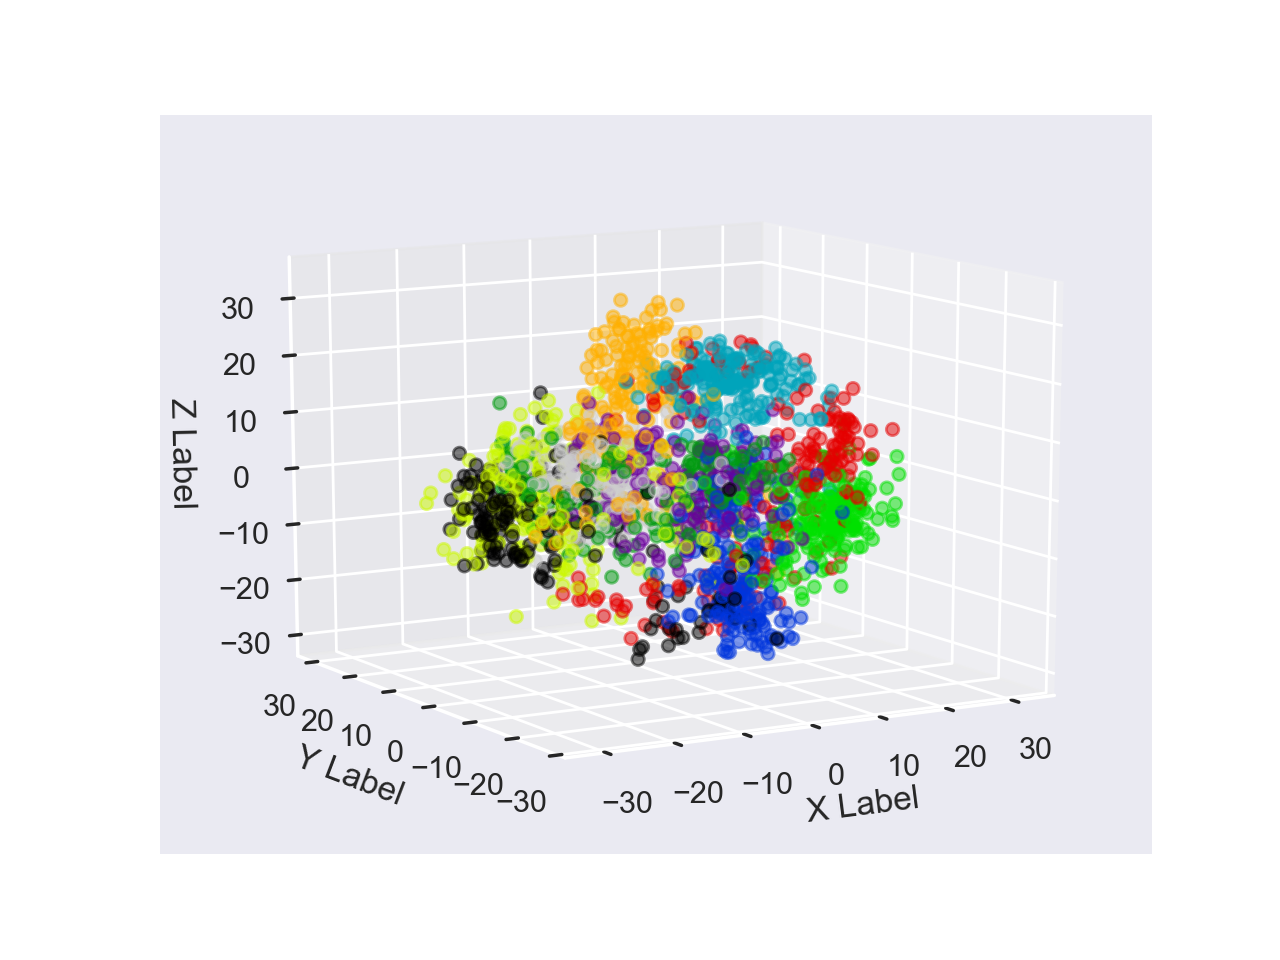

In [242]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

n = 100

ax.scatter(projected[:, 0], projected[:, 1], projected[:,2], c=digits.target, alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral_r', 10))

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

### Exercise/Homework

Apply similar dimension reduction techniques on the `fashion-mnist` and/or `olivetti_faces` datasets that we have studied previously. Are these datasets similarly well-separated?